# CNN + LSTM

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from collections import Counter
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Loading the Dataset
dataset = pd.read_csv('/content/drive/MyDrive/CZ4034/final_dataset.csv')
dataset.drop('Unnamed: 0', axis=1, inplace=True)

# # of rows = 5000, # of cols = 2
print(dataset.shape)

(1306, 2)


In [ ]:
#Exploring the Dataset
print(dataset['flair_labels'].value_counts())

1    653
0    653
Name: flair_labels, dtype: int64


In [ ]:
#Count all the unique words - input to fxn: column [series]
prev_list = []

for review in dataset.Review:
    string_list = review.split(' ')
    string_list += prev_list
    prev_list = string_list

counter = Counter(string_list)

#Getting the number of unique words
num_unique_words = len(counter)

#Getting the top 10 most commonly used words
most_common = counter.most_common(10)

most_common

[('skin', 1334),
 ('product', 458),
 ('like', 380),
 ('love', 330),
 ('using', 324),
 ('use', 324),
 ('face', 309),
 ('really', 275),
 ('dry', 229),
 ('im', 227)]

In [ ]:
#Splitting into trianing and validation splits
x_train, x_test, y_train, y_test = train_test_split(dataset['Review'], dataset['flair_labels'], test_size=0.2, random_state=42)
#x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

print(f"Train: {len(x_train)}")
#print(f"Val: {len(x_val)}")
print(f"Test: {len(x_test)}")
# Train - 1568 , Test - 392

Train: 1044
Test: 262


In [ ]:
#Convert from Series into Numpy Array
train_sentences = x_train.to_numpy()
train_labels = y_train.to_numpy()

#val_sentences = x_val.to_numpy()
#val_labels = y_val.to_numpy()

test_sentences = x_test.to_numpy()
test_labels = y_test.to_numpy()

In [ ]:
#Tokenization - vectorise a text corpus by converting text into a sequence of integers
#this also generates a word index
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

#writing the word index into a text file

with open("/content/drive/MyDrive/CZ4034/final_data_word_idx.txt", 'w') as f:
    f.write(json.dumps(word_index))

In [ ]:
#Converting the text into sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
#val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

#Getting the longest review
MAX_LEN = len(max(train_sequences))

#Padding the Sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
#val_padded = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
print('Train:',train_padded.shape)
#print('Val:',val_padded.shape)
print('Test:',test_padded.shape)
"""
NOTE: 
  • Train Padded Shape: (1568, 22)
  • Valid Padded Shape: (196, 22)
  • Test Padded Shape: (392, 22)
"""

Train: (1044, 40)
Test: (262, 40)


'\nNOTE: \n  • Train Padded Shape: (1568, 22)\n  • Valid Padded Shape: (196, 22)\n  • Test Padded Shape: (392, 22)\n'

In [ ]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
#val_labels = le.fit_transform(val_labels)
test_labels = le.fit_transform(test_labels)

In [ ]:
print(f"Training")
print(f"0: {list(train_labels).count(0)}")
print(f"1: {list(train_labels).count(1)}\n")

#print("Val")
#print(f"0: {list(val_labels).count(0)}")
#print(f"1: {list(val_labels).count(1)}\n")

print("Test")
print(f"0: {list(test_labels).count(0)}")
print(f"1: {list(test_labels).count(1)}\n")

Training
0: 527
1: 517

Test
0: 126
1: 136



## Model Building

In [ ]:
#Creating base model
model = Sequential()

model.add(Embedding(num_unique_words, output_dim=100, input_length=MAX_LEN, trainable=True))
#adding the CONV layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 40, 100)           378900    
                                                                 
 conv1d_8 (Conv1D)           (None, 40, 32)            9632      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 100)               53200     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 441,833
Trainable params: 441,833
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_data=(test_padded, test_labels))

Epoch 1/5
17/17 [==============================] - 7s 214ms/step - loss: 0.6925 - accuracy: 0.5010 - val_loss: 0.6894 - val_accuracy: 0.5458
Epoch 2/5
17/17 [==============================] - 1s 46ms/step - loss: 0.6499 - accuracy: 0.5862 - val_loss: 0.7412 - val_accuracy: 0.6336
Epoch 3/5
17/17 [==============================] - 1s 47ms/step - loss: 0.4013 - accuracy: 0.8103 - val_loss: 0.5172 - val_accuracy: 0.7786
Epoch 4/5
17/17 [==============================] - 1s 45ms/step - loss: 0.1536 - accuracy: 0.9473 - val_loss: 0.8434 - val_accuracy: 0.7481
Epoch 5/5
17/17 [==============================] - 1s 45ms/step - loss: 0.0706 - accuracy: 0.9741 - val_loss: 0.7752 - val_accuracy: 0.7786


In [ ]:
with open('/content/drive/MyDrive/CZ4034/CNN_LSTM/hist_cnn_lstm.txt', 'w') as convert_file:
     convert_file.write(json.dumps(history.history))

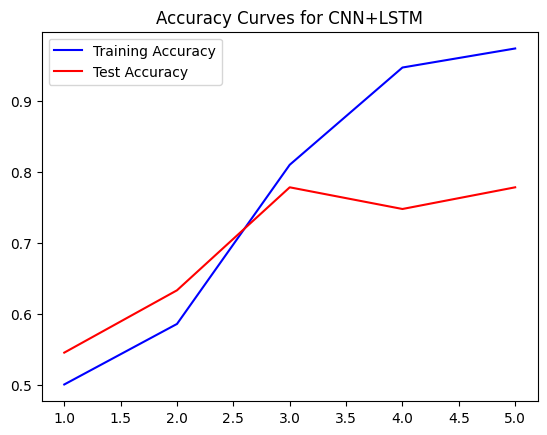

<Figure size 640x480 with 0 Axes>

In [ ]:
#PLOTTING THE CURVES
epochs = range(1,6)

#Plotting the Accuracy Curves
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs,train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy, 'r', label='Test Accuracy')
plt.title('Accuracy Curves for CNN+LSTM')
plt.legend()
plt.figure()
plt.savefig('/content/drive/MyDrive/CZ4034/CNN_LSTM/cnnlstmtry1_Accuracy.jpg')

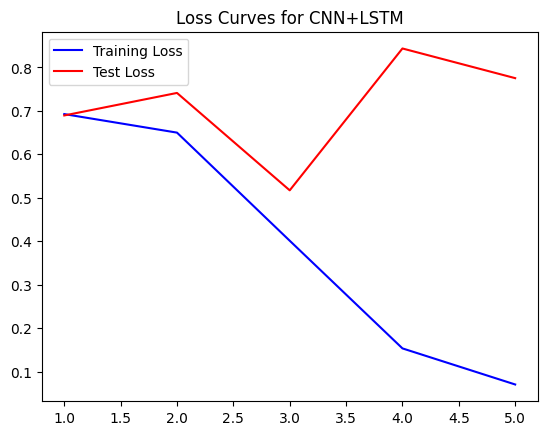

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plotting the Loss Curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs,train_loss, 'b', label='Training Loss')
plt.plot(epochs,val_loss, 'r', label='Test Loss')
plt.title('Loss Curves for CNN+LSTM')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4034/CNN_LSTM/cnnlstm_try1_Loss.png')

In [ ]:
model = load_model('/content/drive/MyDrive/CZ4034/CNN_LSTM/model.hdf5')
model

In [ ]:
scores = model.evaluate(test_padded, test_labels, verbose=1,batch_size = 64)
print("Accuracy: %.2f%%" % (scores[1]*100))

5/5 [==============================] - 0s 12ms/step - loss: 0.7752 - accuracy: 0.7786
Accuracy: 77.86%


In [ ]:
predictions = model.predict(test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

9/9 [==============================] - 1s 9ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(test_labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       126
           1       0.77      0.82      0.79       136

    accuracy                           0.78       262
   macro avg       0.78      0.78      0.78       262
weighted avg       0.78      0.78      0.78       262



In [ ]:
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

True Positives: 111
True Negatives: 93
False Positives: 33
False Negatives: 25


In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171048 sha256=774d0334dd2a229d7aa3ea73460ef6776fe35b15c635aa993883b087b26d99ee
  Stored in directory: /root/.cache/pip/wheels/fa/7a/e9/22dd0515e1bad255e51663ee513a2fa839c95934c5fc301090
Successfully built emoji


In [ ]:
#Function to process the test sample in the same way as the data processing of training
import numpy as np
from cleantext import clean

#takes in a string(text) and returns a padded sequence 
def process_eval_sample(text):
  text = clean(text, no_emoji=True, no_punct=True, lower=True)
  text = text.split(" ")
  sentence = np.array(text)
  sequence = tokenizer.texts_to_sequences(sentence)
  padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

  return padded_sequence

#takes in a padded sequence and returns an integer (0 or 1) for the label
def predict_test_sample(padded_seq):
  predictions = model.predict(padded_seq)[0]
  print(f"Predicted Value: {predictions}")
  pred_values = [1 if p>=0.5 else 0 for p in predictions]
  pred_label = max(pred_values)

  return pred_label

In [ ]:
eval2_text = "I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again."
gt2_label = '0'

eval2 = process_eval_sample(eval2_text)
eval2_label = predict_test_sample(eval2)

print(f"Predictions: {model.predict(eval2)[0]}")
print(f"Eval Sample 2: {eval2_text}")
print(f"Ground Truth Label: {gt2_label}")
print(f"Predicted Label: {eval2_label}")

2/2 [==============================] - 0s 16ms/step
Predicted Value: [0.98648775]
2/2 [==============================] - 0s 16ms/step
Predictions: [0.98648775]
Eval Sample 2: I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again.
Ground Truth Label: 0
Predicted Label: 1


In [ ]:
eval3_text = "best product ever!"
gt3_label = '1'

eval3 = process_eval_sample(eval3_text)
eval3_label = predict_test_sample(eval3)

print(f"Eval Sample 3: {eval3_text}")
print(f"Ground Truth Label: {gt3_label}")
print(f"Predicted Label: {eval3_label}")

1/1 [==============================] - 0s 40ms/step
Predicted Value: [0.98547864]
Eval Sample 3: best product ever!
Ground Truth Label: 1
Predicted Label: 1


In [ ]:
model.save('/content/drive/MyDrive/CZ4034/CNN_LSTM/model.hdf5')